# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.feature_selection import mutual_info_classif

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [93]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 972)


,$I_{3720}$,$I_{3533}$,$I_{3405}$,$I_{3302}$,$I_{3201}$,$I_{3132}$,$I_{3001}$,$I_{2926}$,$I_{2560}$,$I_{2464}$,$I_{2345}$,$I_{2239}$,$I_{1737}$,$I_{1704}$,$I_{1651}$,$I_{1609}$,$I_{1584}$,$I_{1557}$,$I_{1526}$,$I_{1428}$,$I_{1392}$,$I_{1237}$,$I_{1180}$,$I_{1120}$,$I_{1077}$,...,$\frac{\langle I_{1500\text{–}1600} \rangle}{\langle I_{1100\text{–}1200} \rangle}$,$\frac{\langle I_{1500\text{–}1600} \rangle}{\langle I_{1000\text{–}1100} \rangle}$,$\frac{\langle I_{1500\text{–}1600} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1500\text{–}1600} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{1300\text{–}1400} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{1200\text{–}1300} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{1100\text{–}1200} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{1000\text{–}1100} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1400\text{–}1500} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{1300\text{–}1400} \rangle}{\langle I_{1200\text{–}1300} \rangle}$,$\frac{\langle I_{1300\text{–}1400} \rangle}{\langle I_{1100\text{–}1200} \rangle}$,$\frac{\langle I_{1300\text{–}1400} \rangle}{\langle I_{1000\text{–}1100} \rangle}$,$\frac{\langle I_{1300\text{–}1400} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1300\text{–}1400} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{1200\text{–}1300} \rangle}{\langle I_{1100\text{–}1200} \rangle}$,$\frac{\langle I_{1200\text{–}1300} \rangle}{\langle I_{1000\text{–}1100} \rangle}$,$\frac{\langle I_{1200\text{–}1300} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1200\text{–}1300} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{1100\text{–}1200} \rangle}{\langle I_{1000\text{–}1100} \rangle}$,$\frac{\langle I_{1100\text{–}1200} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1100\text{–}1200} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{1000\text{–}1100} \rangle}{\langle I_{900\text{–}1000} \rangle}$,$\frac{\langle I_{1000\text{–}1100} \rangle}{\langle I_{800\text{–}900} \rangle}$,$\frac{\langle I_{900\text{–}1000} \rangle}{\langle I_{800\text{–}900} \rangle}$
division_1_size_bulk,0.084601,0.506784,0.938564,1.000000,0.815223,0.720771,0.498252,0.422644,0.219016,0.143296,0.248711,0.118391,0.378890,0.423317,0.827933,1.0,0.761398,0.494486,0.328826,0.682168,0.819844,0.550066,0.515502,0.745328,0.830578,...,0.802252,0.632888,1.262168,1.824879,0.753337,0.970571,0.856980,0.676062,1.348270,1.949367,1.288363,1.137579,0.897423,1.789731,2.587645,0.882965,0.696561,1.389151,2.008475,0.788889,1.573280,2.274694,1.994300,2.883416,1.445829
division_1_size_5,0.038211,0.652508,1.000000,0.942571,0.814723,0.704920,0.486172,0.448983,0.201775,0.158787,0.191185,0.123498,0.371442,0.417765,0.842104,1.0,0.731738,0.455388,0.277878,0.621557,0.738359,0.508943,0.515948,0.705649,0.664996,...,0.769082,0.826270,1.448366,1.927351,0.772250,0.956124,0.805630,0.865536,1.517196,2.018944,1.238101,1.043224,1.120797,1.964643,2.614364,0.842600,0.905255,1.586819,2.111592,1.074359,1.883242,2.506043,1.752897,2.332593,1.330707
division_1_size_3,0.074497,0.598526,1.000000,0.937402,0.760651,0.637583,0.450708,0.547936,0.203027,0.137535,0.304164,0.126319,0.312673,0.408867,0.852727,1.0,0.819926,0.589477,0.391324,0.644534,0.739963,0.475526,0.618890,0.953037,0.879241,...,0.726594,0.757253,1.418718,2.162281,0.862334,1.090712,0.662785,0.690752,1.294129,1.972393,1.264837,0.768595,0.801026,1.500728,2.287273,0.607663,0.633304,1.186500,1.808355,1.042196,1.952561,2.975915,1.873506,2.855428,1.524109


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class'].tolist()

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [39]:
feature_types_lst = [
    'base_features_peaks_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_3800_2200',
    'base_features_intervals_1900_800',
    'engineered_features_peaks',
    'engineered_features_intervals',
]

In [42]:
sns.set_theme()

# Feature selection

## *Mutual information* analysis

### Functions for calculation and visualization

In [69]:
def compute_and_plot_mutual_info_classif(X, y, top_n=None, plot=False, plot_style=None, path_to_save=None, ax=None):
    mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    result_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mi})
    result_df = result_df.sort_values(by='mutual_info', ascending=False).reset_index(drop=True)

    if top_n:
        result_df = result_df.head(top_n)

    if plot:
        plot_df = result_df.copy()
        plot_df = plot_df.sort_values(by='mutual_info', ascending=True)

        if plot_style is None:
            plot_style = {
                "COLOR": "skyblue",
                "FIGSIZE": (10, 5),
                "TITLE": "Значимость признаков (mutual information)",
                "XLABEL": "Mutual Information",
                "YLABEL": "Признаки",
                "TITLE_FONT_SIZE": 14,
                "X_LABEL_FONT_SIZE": 12,
                "Y_LABEL_FONT_SIZE": 12,
                "X_TICK_LABEL_FONT_SIZE": 10,
                "Y_TICK_LABEL_FONT_SIZE": 10,
            }

        else:
            plot_style = {k.upper(): v for k, v in plot_style.items()}

        created_ax = False
        if ax is None:
            fig, ax = plt.subplots(figsize=plot_style["FIGSIZE"], dpi=300)
            created_ax = True

        bars = ax.barh(plot_df['feature'], plot_df['mutual_info'], color=plot_style["COLOR"])
        
        ax.set_title(plot_style["TITLE"], fontsize=plot_style["TITLE_FONT_SIZE"])
        
        ax.set_xlabel(plot_style["XLABEL"], fontsize=plot_style["X_LABEL_FONT_SIZE"])
        ax.set_ylabel(plot_style["YLABEL"], fontsize=plot_style["Y_LABEL_FONT_SIZE"])

        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_style["X_NBINS"]))
        # ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_style["Y_NBINS"]))
        
        ax.tick_params(axis='x', labelsize=plot_style["X_TICK_LABEL_FONT_SIZE"])
        ax.tick_params(axis='y', labelsize=plot_style["Y_TICK_LABEL_FONT_SIZE"])

        if created_ax:
            plt.tight_layout()
            if path_to_save is not None:
                plt.savefig(path_to_save, dpi=600)
            plt.show()

    return result_df

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from matplotlib import ticker

def compute_and_plot_mutual_info_classif(X, y, top_n=None, plot=False, plot_style=None, path_to_save=None, ax=None):
    mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    result_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mi})
    result_df = result_df.sort_values(by='mutual_info', ascending=False).reset_index(drop=True)

    if top_n:
        result_df = result_df.head(top_n)

    if plot:
        plot_df = result_df.copy()

        if plot_style is None:
            plot_style = {
                "COLOR": "skyblue",
                "FIGSIZE": (10, 5),
                "TITLE": "Значимость признаков (mutual information)",
                "XLABEL": "Признаки",
                "YLABEL": "Mutual Information",
                "TITLE_FONT_SIZE": 14,
                "X_LABEL_FONT_SIZE": 12,
                "Y_LABEL_FONT_SIZE": 12,
                "X_TICK_LABEL_FONT_SIZE": 10,
                "Y_TICK_LABEL_FONT_SIZE": 10,
                "X_NBINS": 20,
                "Y_NBINS": 10,
            }
        else:
            plot_style = {k.upper(): v for k, v in plot_style.items()}

        created_ax = False
        if ax is None:
            fig, ax = plt.subplots(figsize=plot_style["FIGSIZE"], dpi=300)
            created_ax = True

        # seaborn barplot
        sns.barplot(
            data=plot_df,
            x="feature",
            y="mutual_info",
            ax=ax,
            color=plot_style["COLOR"]
        )

        ax.set_title(plot_style["TITLE"], fontsize=plot_style["TITLE_FONT_SIZE"])
        
        ax.set_xlabel(plot_style["XLABEL"], fontsize=plot_style["X_LABEL_FONT_SIZE"])
        ax.set_ylabel(plot_style["YLABEL"], fontsize=plot_style["Y_LABEL_FONT_SIZE"])

        if "X_NBINS" in plot_style:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_style["X_NBINS"]))
        if "Y_NBINS" in plot_style:
            ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_style["Y_NBINS"]))

        ax.tick_params(axis='x', labelsize=plot_style["X_TICK_LABEL_FONT_SIZE"], rotation=0)
        ax.tick_params(axis='y', labelsize=plot_style["Y_TICK_LABEL_FONT_SIZE"])

        plt.tight_layout()
        if created_ax:
            if path_to_save is not None:
                plt.savefig(path_to_save, dpi=600)
            plt.show()

    return result_df


### Interpretation of results

*Config-variable for plotting*

In [91]:
plot_style = {
    "COLOR": "skyblue",
    "FIGSIZE": (10, 6),
    "TITLE": "",
    "XLABEL": "",
    "YLABEL": "$MI$",
    "TITLE_FONT_SIZE": 14,
    "X_LABEL_FONT_SIZE": 12,
    "Y_LABEL_FONT_SIZE": 12,
    "X_TICK_LABEL_FONT_SIZE": 10,
    "Y_TICK_LABEL_FONT_SIZE": 10,
    'X_NBINS': 8
}

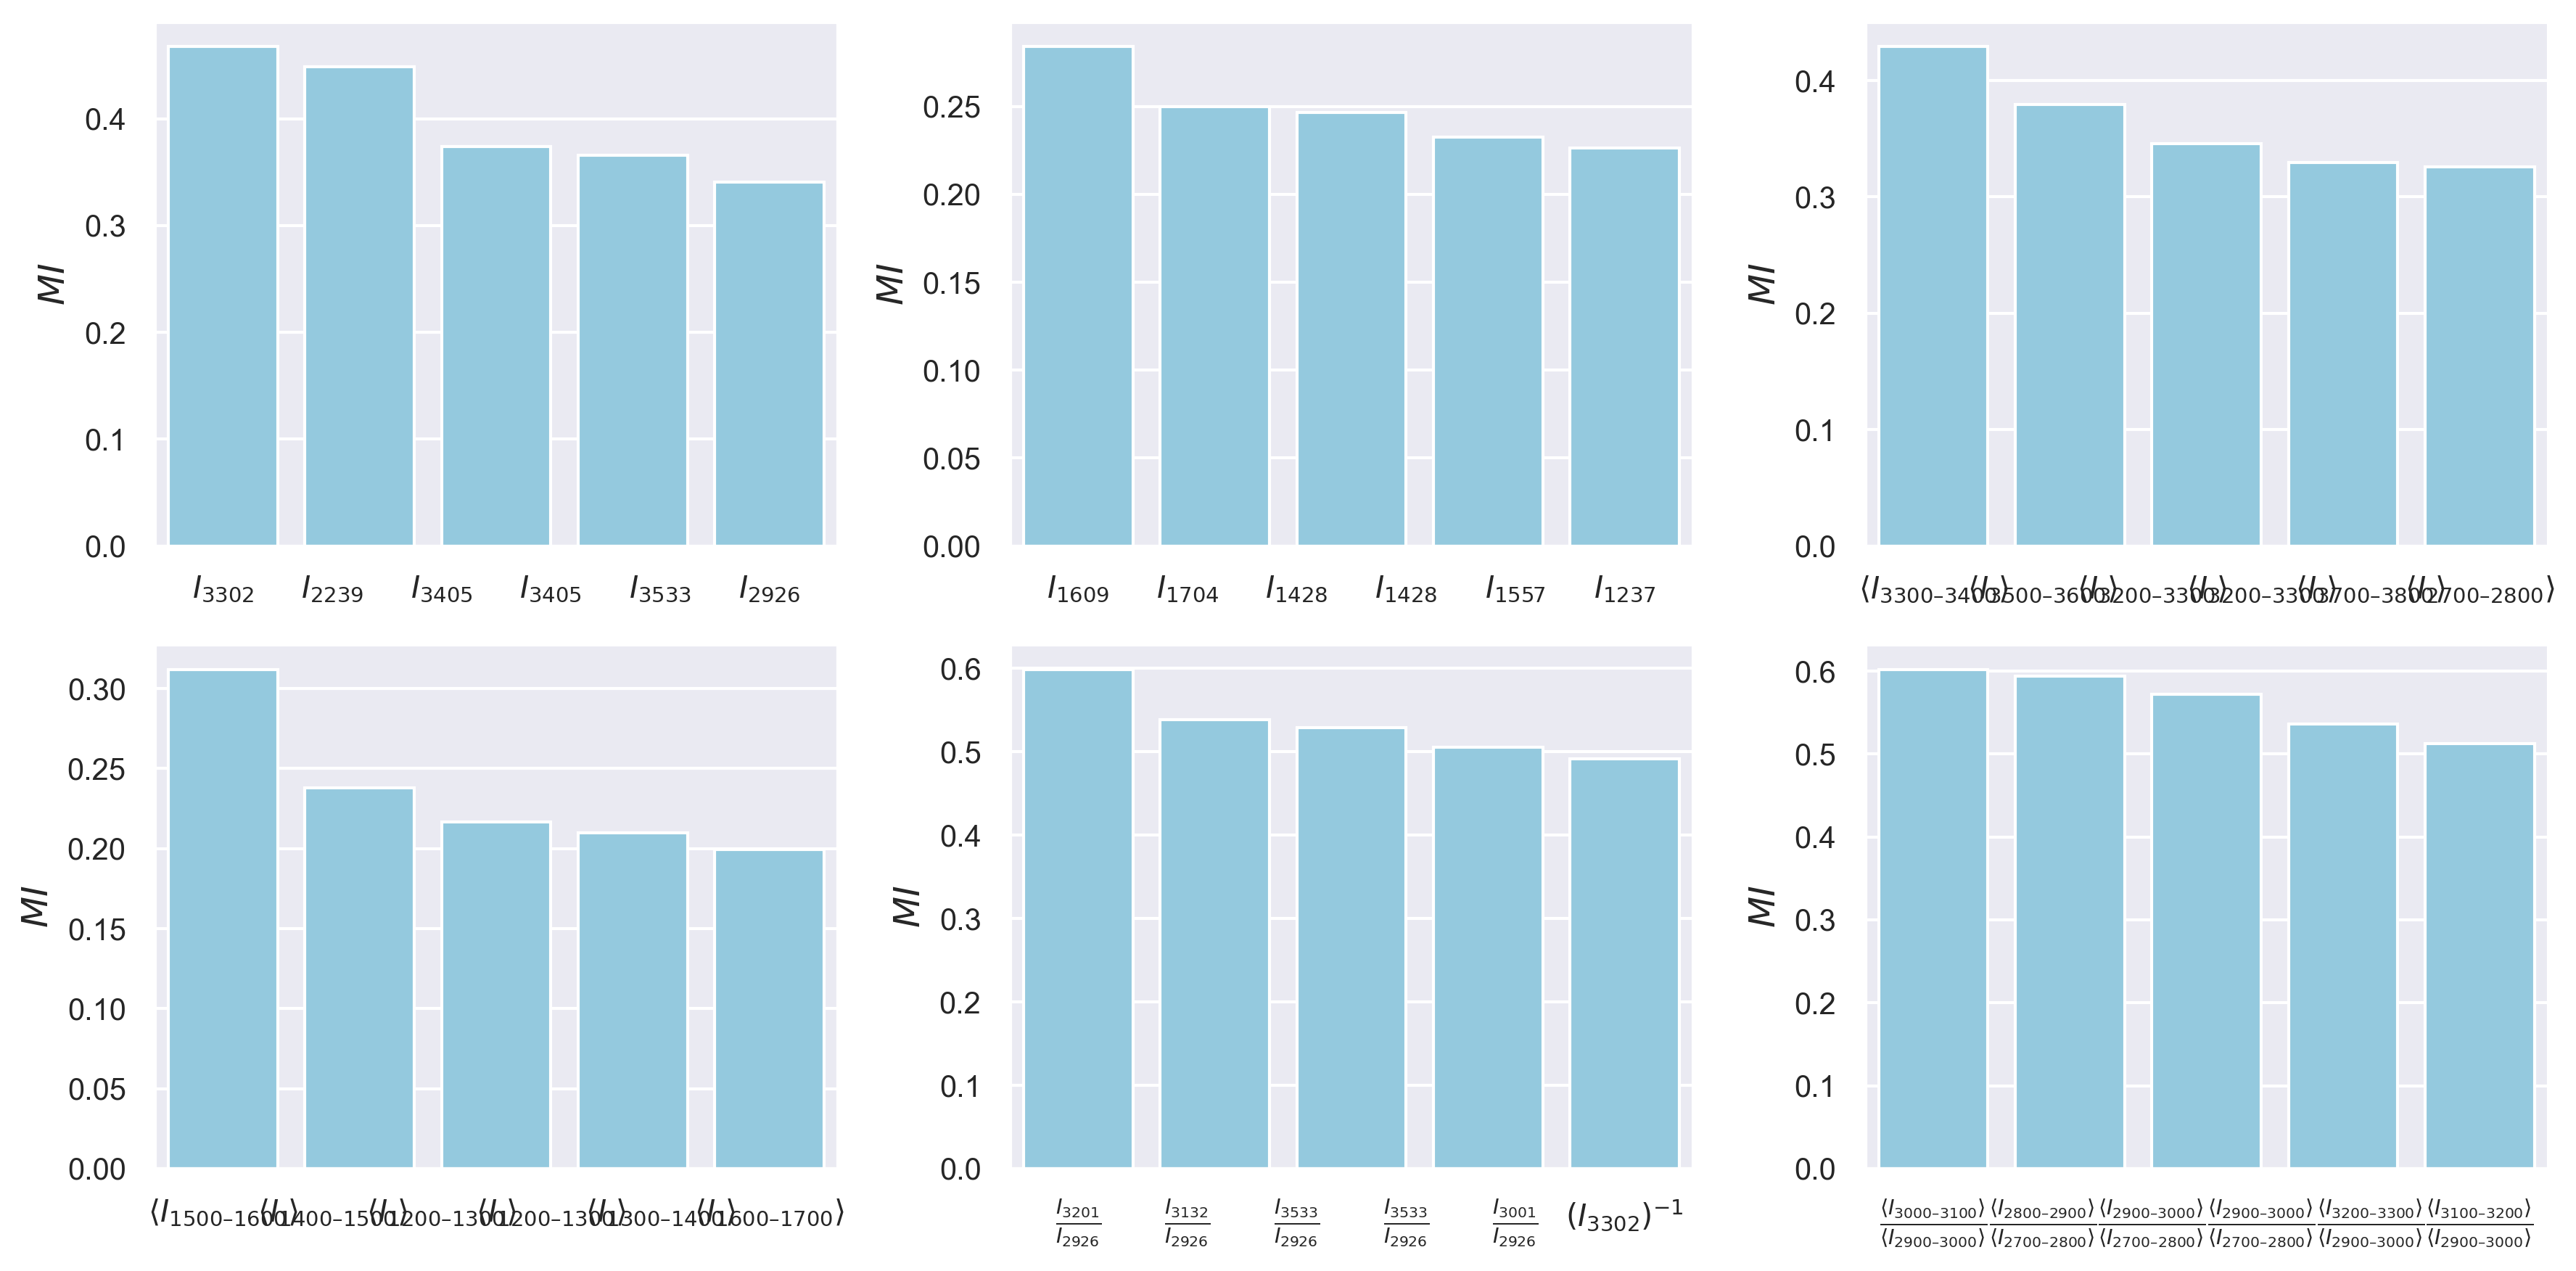

In [92]:
nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, ncols * 2), dpi=300)
axes = list(axes.flat)

for i, feature_type in enumerate(feature_types):

    features_lst = features_description[feature_type]

    compute_and_plot_mutual_info_classif(
        X=features_df[features_lst],
        y=target, top_n=5,
        plot=True,
        plot_style=plot_style,
        ax=axes[i]
    )


plt.tight_layout()

# plt.savefig()

plt.show()